In [1]:
import numpy as np
import os
import imageio
import pickle
from PIL import Image
import ruamel.yaml as yaml
import matplotlib.pyplot as plt

from dreamerv3.embodied import replay as dreamer_replay
from dreamerv3.embodied.core.basics import unpack
from dreamerv3.embodied.core.config import Config
from dreamerv3.embodied.core.path import Path


from utils import scan, setup_video, concatenate_images
colors = ["#800020", "#0F52BA", "#228B22", "#4B0082", "#CC5500"]


In [2]:
eval_trajs = np.load(os.path.join("/home/csancaktar/Projects/new/mbrl","reward_eval_buffers_rendered.npy"),
                    allow_pickle=True)

In [3]:
len(eval_trajs[59]), len(eval_trajs)

(300, 60)

In [4]:
import smart_settings
from motif.reward_model import RewardModel
from motif.eval_utils import get_batch_dict_for_reward_model, reward_model_with_mb

In [5]:
# motif_model_dir = "/fast/csancaktar/results/motif/\
# robodesk_p2e_data/grid_robodesk_p2e_multiple_runs_contrastive_job25/working_directories/0"

# motif_model_dir = "/fast/csancaktar/results/motif/\
# robodesk_p2e_data/grid_robodesk_p2e_multiple_runs_contrastive_job25_rerendered/working_directories/0"
# # motif_model_dir = "/fast/csancaktar/results/motif/\
# # robodesk_p2e_data/grid_robodesk_p2e_multiple_runs_highcontrast1_job25/working_directories/0"


# model_cpt_id = 25
# device = "cuda:0"

In [6]:
# motif_model_dir = "/fast/csancaktar/results/motif/\
# robodesk_p2e_data/grid_robodesk_p2e_multiple_runs_contrastive_gpt4/working_directories/12"

# model_cpt_id = 41
# device = "cuda:0"

In [205]:
motif_model_dir = "/fast/csancaktar/results/motif/robodesk_ceeus_data/grid_robodesk_ceeus_gpt4/working_directories/12"

In [158]:
motif_model_dir = "/fast/csancaktar/results/motif/\
robodesk_ceeus_data/grid_robodesk_ceeus_gpt4/working_directories/12"

model_cpt_id = 41
device = "cuda:0"

In [159]:
# motif_model_dir = "/fast/csancaktar/results/motif/\
# robodesk_ceeus_data/grid_robodesk_ceeus_gpt4/working_directories/17"

# model_cpt_id = 49
# device = "cuda:0"

In [160]:
"/fast/csancaktar/results/motif/robodesk_p2e_data/grid_robodesk_p2e_multiple_runs_contrastive_gpt4/working_directories/12"

'/fast/csancaktar/results/motif/robodesk_p2e_data/grid_robodesk_p2e_multiple_runs_contrastive_gpt4/working_directories/12'

In [206]:
params = smart_settings.load(os.path.join(motif_model_dir, "settings.json"), make_immutable=False)
motif_reward_model = RewardModel(params["reward_model_params"]["model_params"], device=device)
motif_reward_model.load(
    os.path.join(motif_model_dir, f"checkpoint_{model_cpt_id}")
)

In [207]:
og_motif_model_dir = "/is/rg/al/Datasets/robodesk/Robodesk/motif_reward/motif_highres_image"
params_og = smart_settings.load(os.path.join(og_motif_model_dir, "settings.json"), make_immutable=False)
motif_reward_model_og = RewardModel(params_og["reward_model_params"]["model_params"], device=device)
motif_reward_model_og.load(
    os.path.join(og_motif_model_dir, f"checkpoint_{model_cpt_id}")
)

In [163]:
import copy
# motif_trajs1 = copy.deepcopy(motif_trajs)

In [164]:
motif_trajs = []
motif_trajs_og = []

for eval_traj in eval_trajs:
    eval_traj_array = np.asarray(eval_traj)
    # shape: t, width, height, 3
    
    rollout_images = eval_traj_array

    obs_vec = None
    rollout_images_left = None
    batch_dict = get_batch_dict_for_reward_model(
        motif_reward_model, rollout_images, obs_vec
    )
    reward_dict = reward_model_with_mb(motif_reward_model, batch_dict)

    # motif_reward = reward_dict.rewards.squeeze().detach().cpu().numpy().item()
    motif_reward = reward_dict.rewards.squeeze().detach().cpu().numpy()
    motif_trajs.append(motif_reward)
    
    reward_dict_og = reward_model_with_mb(motif_reward_model_og, batch_dict)
    motif_reward_og = reward_dict_og.rewards.squeeze().detach().cpu().numpy()
    motif_trajs_og.append(motif_reward_og)

In [195]:
rollout_i = 24

Text(0, 0.5, 'Motif reward')

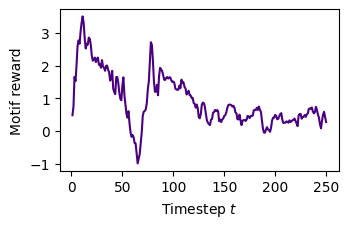

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(3.6, 2.1))
x_axis = np.arange(1, len(motif_trajs[rollout_i]) + 1)

# ax.plot(x_axis, motif_trajs1[rollout_i], color=colors[0], linewidth=1.5)

ax.plot(x_axis, motif_trajs[rollout_i], color=colors[3], linewidth=1.5)

# ax.plot(x_axis, np.clip(motif_trajs[rollout_i], -15, 50), color=colors[0], linewidth=1.5)

ax.set_xlabel(r"Timestep $t$")
ax.set_ylabel(r"Motif reward")


Text(0, 0.5, 'Motif reward')

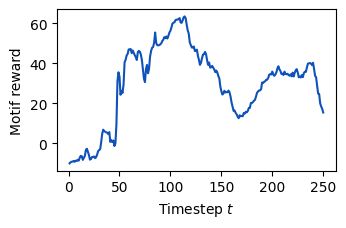

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(3.6, 2.1))
x_axis = np.arange(1, len(motif_trajs_og[rollout_i]) + 1)

ax.plot(x_axis, motif_trajs_og[rollout_i], color=colors[1], linewidth=1.5)
# ax.plot(x_axis, np.clip(motif_trajs[rollout_i], -10, 50), color=colors[0], linewidth=1.5)

ax.set_xlabel(r"Timestep $t$")
ax.set_ylabel(r"Motif reward")

In [198]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

# tslearn.metrics.cdist_dtw(dataset1, dataset2=None, global_constraint=None, sakoe_chiba_radius=None, itakura_max_slope=None, n_jobs=None, verbose=0, be=None)


In [199]:
# os.makedirs("test_motif_runs2", exist_ok=True)
# for rollout_i in range(len(motif_trajs_og)):
    
#     fig, ax = plt.subplots(1, 1, figsize=(3.6, 2.1))
#     x_axis = np.arange(1, len(motif_trajs[rollout_i]) + 1)

#     ax.plot(x_axis, motif_trajs1[rollout_i], color=colors[0], linewidth=1.5)

#     ax.plot(x_axis, motif_trajs[rollout_i], color=colors[3], linewidth=1.5)
    
#     ax.set_xlabel(r"Timestep $t$")
#     ax.set_ylabel(r"Motif reward")

#     plt.savefig(os.path.join("test_motif_runs", f"p2e_contrastive2_motif_rollout_{rollout_i}.png"))
    
#     fig, ax = plt.subplots(1, 1, figsize=(3.6, 2.1))
#     x_axis = np.arange(1, len(motif_trajs_og[rollout_i]) + 1)

#     ax.plot(x_axis, motif_trajs_og[rollout_i], color=colors[1], linewidth=1.5)
#     # ax.plot(x_axis, np.clip(motif_trajs[rollout_i], -10, 50), color=colors[0], linewidth=1.5)

#     ax.set_xlabel(r"Timestep $t$")
#     ax.set_ylabel(r"Motif reward")
#     plt.savefig(os.path.join("test_motif_runs", f"og_motif_rollout_{rollout_i}.png"))

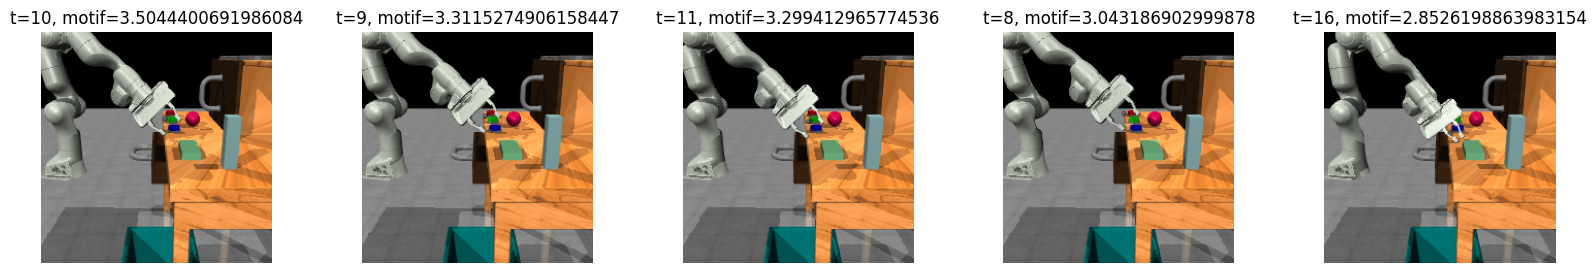

In [200]:
# rollout_i = 31
reward_traj = motif_trajs[rollout_i]
images_traj = np.asarray(eval_trajs[rollout_i])

fig, axs = plt.subplots(1, 5, figsize=(20, 3))

t_list = np.argsort(-reward_traj)[:5]
for i, t in enumerate(t_list):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_traj[t])
    plt.axis("off")
    plt.title(f"t={t}, motif={reward_traj[t]}")
    
# x_axis = np.arange(1, len(reward_traj) + 1)
# axs[0].plot(x_axis, reward_traj, color=colors[0], linewidth=1.5)
# # axs[0].plot(x_axis, gt_baseline, color=colors[1], linewidth=1, linestyle="dashed")
# axs[0].set_xlabel(r"Timestep $t$")
# axs[0].set_ylabel(r"Motif reward")

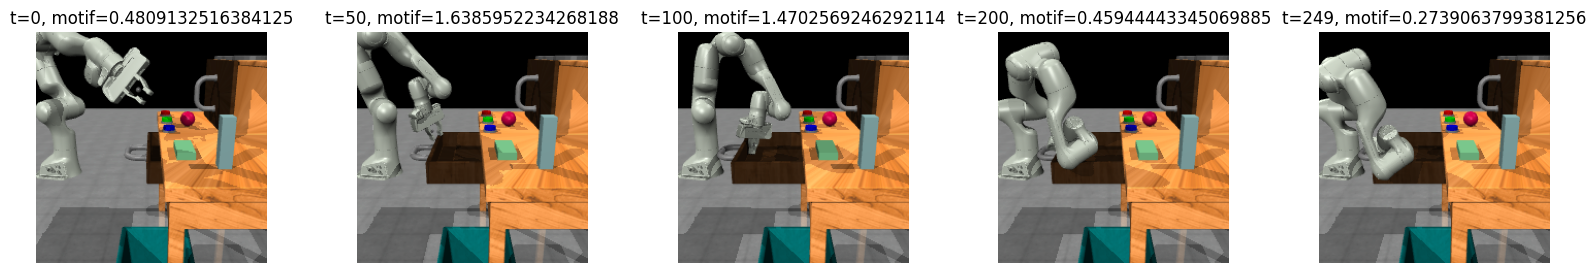

In [201]:
fig, axs = plt.subplots(1, 5, figsize=(20, 3))

t_list = [0, 50, 100, 200, 249]
for i, t in enumerate(t_list):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_traj[t])
    plt.axis("off")
    plt.title(f"t={t}, motif={reward_traj[t]}")

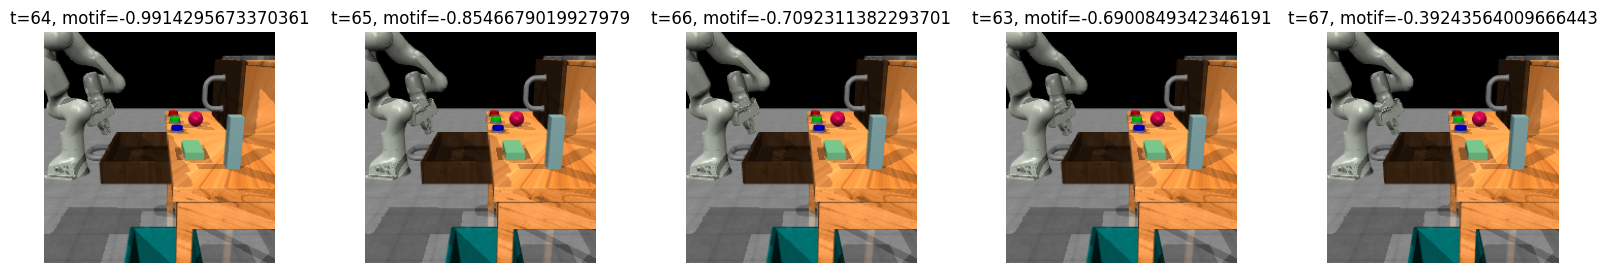

In [202]:
fig, axs = plt.subplots(1, 5, figsize=(20, 3))

t_list = np.argsort(reward_traj)[:5]
for i, t in enumerate(t_list):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_traj[t])
    plt.axis("off")
    plt.title(f"t={t}, motif={reward_traj[t]}")

In [173]:
check_max = -np.inf
check_min = np.inf

In [174]:
for motif_traj in motif_trajs:
    if np.amax(motif_traj) > check_max:
        check_max = np.amax(motif_traj)
    if np.amin(motif_traj) < check_min:
        check_min = np.amin(motif_traj)

In [175]:
check_max, check_min

(3.50444, -4.001636)

In [176]:
## Check median of all data!

In [177]:
with open(os.path.join(params.dataset_dir, "data", "images.pickle"), "rb") as data:
    images_array = pickle.load(data)

In [179]:
images_array = images_array.reshape(-1, 224, 224, 3)

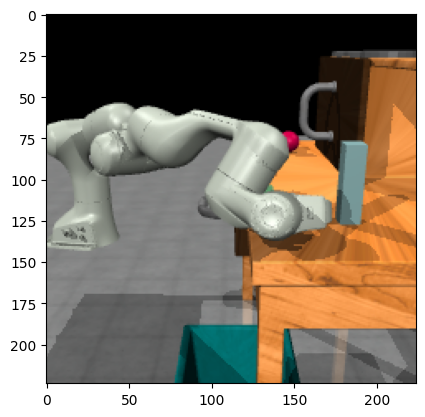

In [180]:
plt.imshow(images_array[1])

In [181]:
all_motif = None
all_motif_og = None

for i in range(0, len(images_array), 500):
    # shape: t, width, height, 3
    
    rollout_images = images_array[i:i+500,...]

    obs_vec = None
    rollout_images_left = None
    batch_dict = get_batch_dict_for_reward_model(
        motif_reward_model, rollout_images, obs_vec
    )
    reward_dict = reward_model_with_mb(motif_reward_model, batch_dict)

    # motif_reward = reward_dict.rewards.squeeze().detach().cpu().numpy().item()
    motif_reward = reward_dict.rewards.squeeze().detach().cpu().numpy()
    
    
    reward_dict_og = reward_model_with_mb(motif_reward_model_og, batch_dict)
    motif_reward_og = reward_dict_og.rewards.squeeze().detach().cpu().numpy()

    
    if all_motif is None:
        all_motif = motif_reward
        all_motif_og = motif_reward_og
    else:
        all_motif = np.concatenate([all_motif, motif_reward])
        all_motif_og = np.concatenate([all_motif_og, motif_reward_og])    

In [204]:
new_perc_thres = 75
np.percentile(all_motif, new_perc_thres), np.percentile(all_motif, 80)    

(0.8607757091522217, 1.0291901111602784)

In [84]:
new_perc_thres = 85
np.percentile(all_motif, new_perc_thres), np.percentile(all_motif, 80)    

(0.5137664973735804, 0.2671544790267945)

In [186]:
np.percentile(all_motif_og, 80), np.percentile(all_motif, 80)  

(4.370160102844239, 1.0291901111602784)

In [68]:
# indices2test = np.where(np.logical_and(all_motif_og<-0.89, all_motif_og>-0.95))[0]
# indices2test = np.where(all_motif_og>2)[0]
# indices2test = np.where(all_motif_og>-0.92)[0]


In [86]:
indices2test_new = np.where(np.logical_and(all_motif<np.percentile(all_motif, new_perc_thres+2), 
                                          all_motif>np.percentile(all_motif, new_perc_thres-2)))[0]


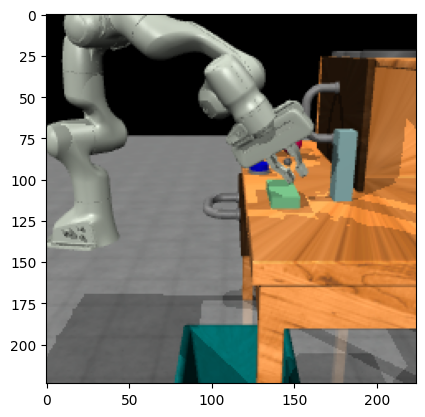

In [87]:
i_test = 9
plt.imshow(images_array[indices2test_new[i_test]])

In [88]:
all_motif[indices2test_new[i_test]], all_motif_og[indices2test_new[i_test]]

(0.5690476, -6.535124)

In [156]:
all_motif_clipped = np.clip(all_motif, -10, 50)

In [157]:
np.percentile(all_motif_clipped, 50)

-10.0